In [1]:
%matplotlib inline

[link text](https://)
Sequence-to-Sequence Modeling with nn.Transformer and TorchText
===============================================================

This is a tutorial on how to train a sequence-to-sequence model
that uses the
`nn.Transformer <https://pytorch.org/docs/master/nn.html?highlight=nn%20transformer#torch.nn.Transformer>`__ module.

PyTorch 1.2 release includes a standard transformer module based on the
paper `Attention is All You
Need <https://arxiv.org/pdf/1706.03762.pdf>`__. The transformer model
has been proved to be superior in quality for many sequence-to-sequence
problems while being more parallelizable. The ``nn.Transformer`` module
relies entirely on an attention mechanism (another module recently
implemented as `nn.MultiheadAttention <https://pytorch.org/docs/master/nn.html?highlight=multiheadattention#torch.nn.MultiheadAttention>`__) to draw global dependencies
between input and output. The ``nn.Transformer`` module is now highly
modularized such that a single component (like `nn.TransformerEncoder <https://pytorch.org/docs/master/nn.html?highlight=nn%20transformerencoder#torch.nn.TransformerEncoder>`__
in this tutorial) can be easily adapted/composed.

![](https://github.com/pytorch/tutorials/blob/gh-pages/_downloads/_static/img/transformer_architecture.jpg?raw=1)





In [2]:
import math
import numpy as np
import os
import sys
import time

import torch
import torch.nn as nn
from torchtext.datasets import WikiText2

In [3]:
print(sys.version)
print(sys.prefix)

3.6.9 (default, Jan 26 2021, 15:33:00) 
[GCC 8.4.0]
/media/homes/msmart/Development/VENVS/HLML2021


In [4]:
LOCAL_MS = os.path.dirname(os.path.abspath(''))
sys.path.append(LOCAL_MS)

from model import TransformerModel, load_model, train, evaluate
from model_usage import gen_some_text
from model_utils import gen_tokenizer_and_vocab, data_process, batchify, get_batch
from settings import BPTT

**Handler: Set Device (CUDA)**

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('torch.cuda.is_available():', torch.cuda.is_available())
print('Device:', device)

torch.cuda.is_available(): True
Device: cuda


**Handler: Colab vs. Local Jupyter**

In [6]:
IN_COLAB = 'google.colab' in str(get_ipython())

if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    NOTEBOOK_OUTDIR = 'MyDrive' + os.sep + 'output'
    %cd '/content/drive'
    TESTMODE = False
    batch_size = 64 #32
    eval_batch_size = 64 #32
    epochs = 50  # The number of epochs
else:
    NOTEBOOK_OUTDIR = 'output'
    TESTMODE = False       # True
    if torch.cuda.is_available():
        batch_size = 64       # 3, or 64/128 on server gpu
        eval_batch_size = 64  # 3, or 64/128 on server gpu
    else:
        batch_size = 3        # 3 on cpu
        eval_batch_size = 3   # 3 on cpu
    epochs = 50  # The number of epochs

os.makedirs(NOTEBOOK_OUTDIR, exist_ok=True)
DATADIR = NOTEBOOK_OUTDIR + os.sep + '.data'

print('Running in colab:', IN_COLAB)
print('Notebook output dir:', NOTEBOOK_OUTDIR)

Running in colab: False
Notebook output dir: output


Define the model
----------------




In this tutorial, we train ``nn.TransformerEncoder`` model on a
language modeling task. The language modeling task is to assign a
probability for the likelihood of a given word (or a sequence of words)
to follow a sequence of words. A sequence of tokens are passed to the embedding
layer first, followed by a positional encoding layer to account for the order
of the word (see the next paragraph for more details). The
``nn.TransformerEncoder`` consists of multiple layers of
`nn.TransformerEncoderLayer <https://pytorch.org/docs/master/nn.html?highlight=transformerencoderlayer#torch.nn.TransformerEncoderLayer>`__. Along with the input sequence, a square
attention mask is required because the self-attention layers in
``nn.TransformerEncoder`` are only allowed to attend the earlier positions in
the sequence. For the language modeling task, any tokens on the future
positions should be masked. To have the actual words, the output
of ``nn.TransformerEncoder`` model is sent to the final Linear
layer, which is followed by a log-Softmax function.




``PositionalEncoding`` module injects some information about the
relative or absolute position of the tokens in the sequence. The
positional encodings have the same dimension as the embeddings so that
the two can be summed. Here, we use ``sine`` and ``cosine`` functions of
different frequencies.




Load and batch data
-------------------




This tutorial uses ``torchtext`` to generate Wikitext-2 dataset. The
vocab object is built based on the train dataset and is used to numericalize
tokens into tensors. Starting from sequential data, the ``batchify()``
function arranges the dataset into columns, trimming off any tokens remaining
after the data has been divided into batches of size ``batch_size``.
For instance, with the alphabet as the sequence (total length of 26)
and a batch size of 4, we would divide the alphabet into 4 sequences of
length 6:

\begin{align}\begin{bmatrix}
  \text{A} & \text{B} & \text{C} & \ldots & \text{X} & \text{Y} & \text{Z}
  \end{bmatrix}
  \Rightarrow
  \begin{bmatrix}
  \begin{bmatrix}\text{A} \\ \text{B} \\ \text{C} \\ \text{D} \\ \text{E} \\ \text{F}\end{bmatrix} &
  \begin{bmatrix}\text{G} \\ \text{H} \\ \text{I} \\ \text{J} \\ \text{K} \\ \text{L}\end{bmatrix} &
  \begin{bmatrix}\text{M} \\ \text{N} \\ \text{O} \\ \text{P} \\ \text{Q} \\ \text{R}\end{bmatrix} &
  \begin{bmatrix}\text{S} \\ \text{T} \\ \text{U} \\ \text{V} \\ \text{W} \\ \text{X}\end{bmatrix}
  \end{bmatrix}\end{align}

These columns are treated as independent by the model, which means that
the dependence of ``G`` and ``F`` can not be learned, but allows more
efficient batch processing.




In [7]:
tokenizer, vocab = gen_tokenizer_and_vocab()

train_iter, val_iter, test_iter = WikiText2(root=DATADIR)
train_data = data_process(train_iter, vocab, tokenizer)
val_data = data_process(val_iter, vocab, tokenizer)
test_data = data_process(test_iter, vocab, tokenizer)

train_data = batchify(train_data, batch_size, device)
val_data = batchify(val_data, eval_batch_size, device)
test_data = batchify(test_data, eval_batch_size, device)

**Code Testing block: shorten the size of the training data to make training loop quicker**

In [8]:
data_reduce = 0.05

if TESTMODE:
    print('TRUNCATING DATA (testmode_ipynb=True)\nShapes before:')
    print(train_data.shape)
    print(test_data.shape)
    print(val_data.shape)
    train_data = train_data[0:int(data_reduce * train_data.shape[0]), :]
    test_data = test_data[0:int(data_reduce * test_data.shape[0]), :]
    val_data = val_data[0:int(data_reduce * val_data.shape[0]), :]
    print('Shapes after:')
    print(train_data.shape)
    print(test_data.shape)
    print(val_data.shape)

``get_batch()`` function generates the input and target sequence for
the transformer model. It subdivides the source data into chunks of
length ``bptt``. For the language modeling task, the model needs the
following words as ``Target``. For example, with a ``bptt`` value of 2,
we’d get the following two Variables for ``i`` = 0:

![](https://github.com/pytorch/tutorials/blob/gh-pages/_downloads/_static/img/transformer_input_target.png?raw=1)


It should be noted that the chunks are along dimension 0, consistent
with the ``S`` dimension in the Transformer model. The batch dimension
``N`` is along dimension 1.




In [9]:
assert BPTT == 35  # TODO override/add flexibility later

Initiate an instance
--------------------




The model is set up with the hyperparameter below. The vocab size is
equal to the length of the vocab object.




In [10]:
ntokens = len(vocab.stoi) # the size of vocabulary

# Model 'A'
"""emsize = 200              # embedding dimension
nhid = 200                # the dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 2               # the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 2                 # the number of heads in the multiheadattention models
dropout = 0.05             # the dropout value"""

# Model 'B'
emsize = 512              # embedding dimension
nhid = 2048               # the dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 12              # the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 8                 # the number of heads in the multiheadattention models
dropout = 0.3             # the dropout value

# Model 'C'
"""
emsize = 1024             # embedding dimension
nhid = 2048               # the dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 12              # the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 16                # the number of heads in the multiheadattention models
dropout = 0.3             # the dropout value"""

# Model 'D' - like GPT-1 - it doesn't fit
# - "BPE with 40,000 merged [53]" using spaCy tokenizer
# - 512 token samples (their BPTT)
# - 100 epochs on minibatches of 64 continuous text streams (each of length BPTT)
# - adam 2.5e-4 with specific LR schedule
# - weight init of N(0, 0.02)
"""
emsize = 768              # embedding dimension
nhid = 3072               # the dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 12              # the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 12                # the number of heads in the multiheadattention models
dropout = 0.1             # the dropout value"""

model = TransformerModel(ntokens, emsize, nhead, nhid, nlayers, dropout).to(device)

Run the model
-------------




`CrossEntropyLoss <https://pytorch.org/docs/master/nn.html?highlight=crossentropyloss#torch.nn.CrossEntropyLoss>`__
is applied to track the loss and
`SGD <https://pytorch.org/docs/master/optim.html?highlight=sgd#torch.optim.SGD>`__
implements stochastic gradient descent method as the optimizer. The initial
learning rate is set to 5.0. `StepLR <https://pytorch.org/docs/master/optim.html?highlight=steplr#torch.optim.lr_scheduler.StepLR>`__ is
applied to adjust the learn rate through epochs. During the
training, we use
`nn.utils.clip_grad_norm\_ <https://pytorch.org/docs/master/nn.html?highlight=nn%20utils%20clip_grad_norm#torch.nn.utils.clip_grad_norm_>`__
function to scale all the gradient together to prevent exploding.




In [11]:
criterion = nn.CrossEntropyLoss()

optimizer_str = 'SGD'
valid_optimizer_str = ['SGD', 'adam', 'adamW']

assert optimizer_str in valid_optimizer_str
scheduler = None
if optimizer_str == 'SGD':
    lr = 0.5  # learning rate (originally: 5.0, 0.1, 0.5 (best))
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    #scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)
elif optimizer_str == 'adam':
    lr = 2.5e-4  # default 1e-3, best 1e-4, try also 2.5e-4
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    print('TODO: check usage of scheduler with adam -- none for now')
else:
    assert optimizer_str == 'adamW'
    lr = 2.5e-4  # default 1e-3, best 1e-4
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    print('TODO: check usage of scheduler with adamW -- none for now')
    
# TODO try two-stage LR like in GPT-1 -- increase 0 to eta_0 over k steps then cosine schedule after

Optionally generate text each epoch to illustrate model state during training

In [ ]:
gen_text_each_epoch = True
# default behaviour generate sentence 1 greedily, then nseed sentences with beta=1
if gen_text_each_epoch:
    decode_seeds = [0, 1, 2]
    decode_betas = [1.0, 1.0, 1.0]
    nongreedy_style = 'sample_full'
    
def gen_some_text_wrapper(generator_model, decode_style):
    generated_text = gen_some_text(
        generator_model, 
        device,
        text_prompt='The dog ran',
        tokens_to_gen=15,
        decode_style=decode_style,
        decode_seed=decode_seed,
        decode_beta=1.0,
        sidestep_unk=False,
        vis=False,
        verbose=False)
    return generated_text

def decode_during_training(generator_model, epoch):
    print('Generated text at epoch %d:' % epoch)
    # First get greedy decoding
    greedy_text = gen_some_text_wrapper(generator_model, 'greedy')
    print("Greedy text:\n%s" % (greedy_text))
    # Now get several sampler decodings
    for idx in len(decode_seed):
        generated_text = gen_some_text_wrapper(generator_model, nongreedy_style)
        print("(seed=%d, beta=%.2f) Generated_text:\n%s" % (decode_seeds[idx], decode_betas[idx], generated_text))

Loop over epochs. Save the model if the validation loss is the best
we've seen so far. Adjust the learning rate after each epoch.



In [12]:
batch_per_epoch = len(train_data) // BPTT
if (len(train_data) - 1) % BPTT != 0:
    batch_per_epoch += 1

training_ppl_train_fine = np.zeros(epochs * batch_per_epoch)
training_ppl_val_coarse = np.zeros(epochs)

best_val_loss = float("inf")
best_model = None

if gen_text_each_epoch:
    decode_during_training(model, epoch)

for epoch in range(1, epochs + 1):
        
    epoch_start_time = time.time()
    loss_per_batch = train(model, device, train_data, ntokens, optimizer, criterion, epoch, scheduler=scheduler)
    
    # print validation loss info each epoch
    validation_loss = evaluate(model, val_data, device, ntokens, criterion)
    validation_ppl = math.exp(validation_loss)
    print('-' * 89)
    print('| end of epoch {:3d} | time: {:5.2f}s | valid loss {:5.2f} | '
          'valid ppl {:8.2f}'.format(epoch, (time.time() - epoch_start_time),
                                     validation_loss, validation_ppl))
    print('-' * 89)
    
    # store loss info
    training_ppl_val_coarse[epoch-1] = validation_ppl
    training_ppl_train_fine[(epoch-1) * batch_per_epoch: (epoch)*batch_per_epoch] = np.exp(loss_per_batch)
    
    # save best model so far
    if validation_loss < best_val_loss:
        best_val_loss = validation_loss
        torch.save(model.state_dict(), NOTEBOOK_OUTDIR + os.sep + 'bestval_model_weights.pth')
        torch.save(model, NOTEBOOK_OUTDIR + os.sep + 'bestval_model.pth')
    if scheduler is not None:
        scheduler.step()
    
    # optionally generate text based on fixed text-prompt
    if gen_text_each_epoch:
        decode_during_training(model, epoch)

| epoch   1 |   200/  915 batches | lr 0.50 | ms/batch 174.84 | loss  7.92 | ppl  2758.10
| epoch   1 |   400/  915 batches | lr 0.50 | ms/batch 174.73 | loss  7.35 | ppl  1561.06
| epoch   1 |   600/  915 batches | lr 0.50 | ms/batch 175.33 | loss  7.16 | ppl  1291.61
| epoch   1 |   800/  915 batches | lr 0.50 | ms/batch 175.49 | loss  6.99 | ppl  1088.37
-----------------------------------------------------------------------------------------
| end of epoch   1 | time: 165.46s | valid loss  6.56 | valid ppl   703.72
-----------------------------------------------------------------------------------------
| epoch   2 |   200/  915 batches | lr 0.47 | ms/batch 176.69 | loss  6.77 | ppl   867.34
| epoch   2 |   400/  915 batches | lr 0.47 | ms/batch 176.06 | loss  6.67 | ppl   788.86
| epoch   2 |   600/  915 batches | lr 0.47 | ms/batch 176.10 | loss  6.58 | ppl   722.83
| epoch   2 |   800/  915 batches | lr 0.47 | ms/batch 176.02 | loss  6.56 | ppl   705.33
-------------------------

**Save Model**

Approach 1: save model weights,
load as: 

  `model.load_state_dict(torch.load('model_weights.pth'))`    
  `model.eval()`
  
Approach 2: save model class object entirely (uses pickle),
load as: 
  `model = torch.load('model.pth')`

In [13]:
torch.save(model.state_dict(), NOTEBOOK_OUTDIR + os.sep + 'end_model_weights.pth')
torch.save(model, NOTEBOOK_OUTDIR + os.sep + 'end_model.pth')

Evaluate the model with the test dataset
-------------------------------------

Assess the model from the end of training (last epoch) on test set.

In [14]:
datachoices = {'train': train_data, 
               'val': val_data,
               'test': test_data}

for datalabel in ['train', 'val', 'test']:
    data_loss = evaluate(model, datachoices[datalabel], device, ntokens, criterion)
    print('=' * 89)
    print('| End of training | {} loss {:5.2f} | {} ppl {:8.2f}'.format(
        datalabel, data_loss, datalabel, math.exp(data_loss)))
    print('=' * 89)

| End of training | train loss  6.23 | train ppl   509.38
| End of training | val loss  6.05 | val ppl   422.47
| End of training | test loss  5.98 | test ppl   393.61


Load the best model (lowest validation loss) to check the result with the test dataset.

In [15]:
best_model = load_model(NOTEBOOK_OUTDIR + os.sep + 'bestval_model.pth',
                        device, 
                        as_pickle=True)

datachoices = {'train': train_data, 
               'val': val_data,
               'test': test_data}

for datalabel in ['train', 'val', 'test']:
    data_loss = evaluate(best_model, datachoices[datalabel], device, ntokens, criterion)
    print('=' * 89)
    print('| End of training | {} loss {:5.2f} | {} ppl {:8.2f}'.format(
        datalabel, data_loss, datalabel, math.exp(data_loss)))
    print('=' * 89)

| End of training | train loss  6.23 | train ppl   509.38
| End of training | val loss  6.05 | val ppl   422.47
| End of training | test loss  5.98 | test ppl   393.61


# Plot training timeseries

In [16]:
np.savetxt(NOTEBOOK_OUTDIR + os.sep + 'training_ppl_train_fine.txt', training_ppl_train_fine)
np.savetxt(NOTEBOOK_OUTDIR + os.sep + 'training_ppl_val_coarse.txt', training_ppl_val_coarse)

In [17]:
import matplotlib.pyplot as plt

epochs_axis = np.arange(1, epochs + 1)
epochs_axis_fine = np.linspace(0, epochs, epochs * batch_per_epoch + 1)[:-1]

def plot_training_timeseries(fname='training_performance', ext='.jpg', logy=True, xlims=None, ylims=None):

    plt.figure(figsize=(8,6))
    plt.plot(epochs_axis, training_ppl_val_coarse, '--ok', label='val', zorder=2)
    plt.plot(epochs_axis_fine, training_ppl_train_fine, 'b', label='train', zorder=1, alpha=0.5)
    plt.xlabel('epoch')
    plt.ylabel('ppl (validation set)')
    plt.legend()
    if logy:
        plt.yscale('log')
        fname += '_logy'
    if xlims is not None:
        plt.xlim(xlims[0], xlims[1])
    if ylims is not None:
        plt.ylim(ylims[0], ylims[1])
    plt.savefig(NOTEBOOK_OUTDIR + os.sep + fname + ext)
    plt.show()

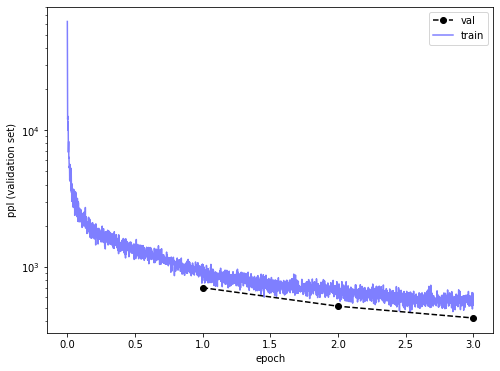

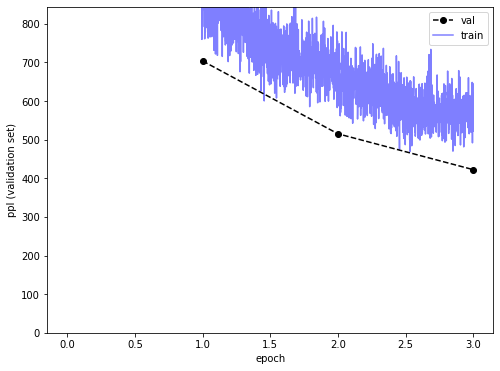

In [18]:
plot_training_timeseries(logy=True)
plot_training_timeseries(logy=False, ylims=(0, np.max(training_ppl_val_coarse) * 1.2))

In [19]:
print('Epoch after which validation loss is minimized (defines best_model):', np.argmin(training_ppl_val_coarse) + 1)

Epoch after which validation loss is minimized (defines best_model): 3
